In [1]:
"""
This note book analyzes how density AND LID together relate to reconstruction loss.
"""

'\nThis note book analyzes how density AND LID together relate to reconstruction loss.\n'

In [2]:
import json
import os
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy as np
sys.path.append(os.path.abspath("../../.."))   # one level up from notebook/
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from data.utils.dataloaders import clean_ReconstructionDataset_Heuristic
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read reconstruction loss json file 
with open('/BS/data_mani_compress/work/thesis/thesis/data/datasets/imagenet_reconstruction_losses/val_categorized/all_APG_on.json', 'r') as f:
    reconst_losses = json.load(f)

In [4]:
k_values = [1,2,4,8,16,32,64,128,256]

best_lids = [26,26,25,25,24,24,23,14,14]
best_lids_per_k = {}
for best_lid, k in zip(best_lids, k_values):
    LID_JSON   = f"/BS/data_mani_compress/work/thesis/thesis/data/datasets/imageNet_LID_values/original_images/val/t_{best_lid}/lid_0000_3125.json"
    # Load LID values; we assume it's ordered so that index i corresponds to image i
    with open(LID_JSON, 'r') as f:
        lid_values = json.load(f)
    best_lids_per_k[k] = lid_values

print('Sizes:', {k: len(v) for k, v in best_lids_per_k.items()})

Sizes: {1: 50000, 2: 50000, 4: 50000, 8: 50000, 16: 50000, 32: 50000, 64: 50000, 128: 50000, 256: 50000}


In [5]:
# load densities
main_folder = "/BS/data_mani_compress/work/thesis/thesis/data/datasets/density_imagenet/clean/list_version/val_density_div_list_reconst_"

density_dict = {}
for k in k_values:
    with open((main_folder + f"{k}/token_count/256_0000_0200.json"), 'r') as f:
        current_densities = json.load(f)
    density_dict[k]=current_densities

print(density_dict.keys(), len(density_dict[1]), len(density_dict[2]), len(density_dict[4]), len(density_dict[8]), len(density_dict[16]), len(density_dict[32]), len(density_dict[64]), len(density_dict[128]), len(density_dict[256]))

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256]) 4000 4000 4000 4000 4000 4000 4000 4000 4000


In [6]:
processed_density_dict = {}
timestep_needed = [0,0,0,0,0,0,0,3,4]
for idx, (key, value) in enumerate(density_dict.items()):
    processed_density_dict[key] = [sum(v[0][timestep_needed[idx]:]) for v in value]

In [7]:
max_available = len(density_dict[1])  # max available

# Filter reconstruction entries to those that have available heuristics (density and LID)
filtered_reconst_losses = [
    rec for rec in reconst_losses
    if 'image_id' in rec and int(rec['image_id']) < max_available
]

ds = clean_ReconstructionDataset_Heuristic(
    reconstruction_data=filtered_reconst_losses,  # or your processed list of dicts
    local_density_information=processed_density_dict, # [l[0] for l in density]
    lid_information=best_lids_per_k,
    error_key=["LPIPS"],
)

In [8]:
print(ds[0])

{'LPIPS': 0.6646087765693665, 'k_value': 1, 'image_id': 0, 'lid': -4511392.0, 'local_density': 25703.694915771484}


In [9]:
"""Fit separate models per k value to predict LPIPS from density and LID."""

models = {}   # k -> fitted model

for k in k_values:
    densities = []
    lids = []
    losses = []

    for dp in ds:

        if dp["k_value"] == k:
            densities.append(dp["local_density"])
            lids.append(dp["lid"])
            losses.append(dp["LPIPS"])
            
    if len(densities) < 5:
        continue

    X = np.stack([densities, lids], axis=1)
    y = np.array(losses)

    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)

    models[k] = model

In [10]:
def predict_k_from_loss(lpips, density, lid, models):
    """
    Predict k based on which model gives the closest LPIPS prediction
    """
    best_k = None
    best_error = float("inf")
    best_pred_lpips = None

    for k, model in models.items():
        pred_lpips = model.predict([[density, lid]])[0]
        error = abs(pred_lpips - lpips)

        if error < best_error:
            best_error = error
            best_k = k
            best_pred_lpips = pred_lpips

    return best_k, best_pred_lpips, best_error


In [11]:
k_vals = np.array([1,2,4,8,16,32,64,128,256])
lpips_means = np.array([
    0.6641367216134071,
    0.6390045218294859,
    0.5810772976367176,
    0.5412031808558107,
    0.5040336578929424,
    0.4624336672103405,
    0.4260499442347512,
    0.37830494250804186,
    0.324529645893015
])
logk = np.log2(k_vals)

lpips_slope = np.abs(np.gradient(lpips_means, logk))
lpips_weight = lpips_slope / lpips_slope.max()

In [12]:

k_values = np.array([1,2,4,8,16,32,64,128,256])
k_to_idx = {int(k): i for i, k in enumerate(k_values)}  # maps k -> index 0..8

lpips_errors = []
k_abs_errors = []
k_idx_errors = []          # error in "doubling steps" (log2 units)
weighted_step_errors = []
within_1_step = 0
within_2_steps = 0
correct = 0
total = 0

for dp in ds:
    true_k = int(dp["k_value"])
    lpips = dp["LPIPS"]
    density = dp["local_density"]
    lid = dp["lid"]

    if true_k not in models:
        continue
    k_hat, pred_lpips, lpips_err = predict_k_from_loss(
        lpips=lpips, density=density, lid=lid, models=models
    )
    

    k_hat = int(k_hat)

    # LPIPS error (already absolute)
    lpips_errors.append(lpips_err)

    # Raw k absolute error (can look big because k is log-spaced)
    k_abs_errors.append(abs(k_hat - true_k))

    # "Step" error: how many doublings off (|log2(k_hat) - log2(true_k)|)
    true_idx = k_to_idx[true_k]
    pred_idx = k_to_idx[k_hat]
    step_err = abs(pred_idx - true_idx)
    k_idx_errors.append(step_err)
    w = lpips_weight[true_idx]

    weighted_step_errors.append(step_err * w)

    # Within-neighborhood accuracies
    if step_err == 0:
        correct += 1
    if step_err <= 1:
        within_1_step += 1
    if step_err <= 2:
        within_2_steps += 1

    total += 1


In [13]:
# Aggregate metrics
lpips_mae  = float(np.mean(lpips_errors))
lpips_rmse = float(np.sqrt(np.mean(np.square(lpips_errors))))

k_mae_raw  = float(np.mean(k_abs_errors))
k_rmse_raw = float(np.sqrt(np.mean(np.square(k_abs_errors))))

# The key metrics for log-spaced k:
step_mae   = float(np.mean(k_idx_errors))                  # average #doublings off
acc_exact  = correct / total
acc_1step  = within_1_step / total
acc_2step  = within_2_steps / total

print("Evaluation (better for log-spaced k):")
print(f"LPIPS MAE:                {lpips_mae:.4f}")
print(f"k MAE:                    {k_mae_raw:.2f}")
print(f"Step MAE:                 {step_mae:.3f}")
print(f"Accuracy exact:           {acc_exact*100:.2f}%")
print(f"Accuracy within ±1 step:  {acc_1step*100:.2f}%   (neighbor ok)")
print(f"Accuracy within ±2 steps: {acc_2step*100:.2f}%")
print(f"Weighted step MAE:        {np.mean(weighted_step_errors):.2f}")


Evaluation (better for log-spaced k):
LPIPS MAE:                0.0173
k MAE:                    22.89
Step MAE:                 1.104
Accuracy exact:           36.54%
Accuracy within ±1 step:  70.96%   (neighbor ok)
Accuracy within ±2 steps: 87.86%
Weighted step MAE:        0.86


In [16]:
within_1_step_weighted = 0
within_2_steps_weighted = 0

for dp in ds:
    true_k = int(dp["k_value"])
    lpips = dp["LPIPS"]
    density = dp["local_density"]
    lid = dp["lid"]
    if true_k not in models:
        continue

    k_hat, pred_lpips, lpips_err = predict_k_from_loss(
        lpips=lpips, density=density, lid=lid, models=models
    )

    k_hat = int(k_hat)

    # indices
    true_idx = k_to_idx[true_k]
    pred_idx = k_to_idx[k_hat]

    # step error
    step_err = abs(pred_idx - true_idx)

    # weight at this k
    w = lpips_weight[true_idx]

    weighted_err = step_err * w

    # unweighted neighborhood (you already have)
    if step_err <= 1:
        within_1_step += 1
    if step_err <= 2:
        within_2_steps += 1

    # 🔥 weighted neighborhood (NEW)
    if weighted_err <= 1.0 * w:
        within_1_step_weighted += 1
    if weighted_err <= 2.0 * w:
        within_2_steps_weighted += 1

    total += 1


In [17]:
print("Accuracy (unweighted):")
print(f"Exact                : {100 * correct / total:.2f}%")
print(f"Within ±1 step       : {100 * within_1_step / total:.2f}%")
print(f"Within ±2 steps      : {100 * within_2_steps / total:.2f}%")

print("\nAccuracy (LPIPS-weighted):")
print(f"Within ±1 step (w)   : {100 * within_1_step_weighted / total:.2f}%")
print(f"Within ±2 steps (w)  : {100 * within_2_steps_weighted / total:.2f}%")


Accuracy (unweighted):
Exact                : 18.27%
Within ±1 step       : 70.96%
Within ±2 steps      : 87.86%

Accuracy (LPIPS-weighted):
Within ±1 step (w)   : 35.48%
Within ±2 steps (w)  : 43.93%


In [19]:
# tolerance in LPIPS (you can sweep this later)
lpips_tol = 0.02
lpips_vals = np.array([item['LPIPS'] for item in reconst_losses])

num_bins = 10
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(lpips_vals, quantiles)

# numerical safety
bin_edges[0] -= 1e-6
bin_edges[-1] += 1e-6
num_bins = len(bin_edges) - 1
bin_logk_lpips_only = [[] for _ in range(num_bins)]
bin_logk_lpips_struct = [[] for _ in range(num_bins)]

# ---------- LPIPS-only (baseline) ----------
for item in ds:
    lpips = item['LPIPS']
    k = item['k_value']

    bin_idx = np.searchsorted(bin_edges, lpips, side='right') - 1
    bin_idx = min(max(bin_idx, 0), num_bins - 1)

    bin_logk_lpips_only[bin_idx].append((k))

# ---------- LPIPS + density/LID ----------
for item in ds:
    lpips = item['LPIPS']
    density = item['local_density']
    lid = item['lid']

    bin_idx = np.searchsorted(bin_edges, lpips, side='right') - 1
    bin_idx = min(max(bin_idx, 0), num_bins - 1)

    plausible_logks = []

    for k, model in models.items():
        pred_lpips = model.predict([[density, lid]])[0]
        if abs(pred_lpips - lpips) <= lpips_tol:
            plausible_logks.append((k))

    if len(plausible_logks) > 0:
        bin_logk_lpips_struct[bin_idx].extend(plausible_logks)


In [20]:
print("LPIPS-only vs LPIPS + (density, LID) ambiguity:\n")

for i in range(num_bins):
    lpips_range = f"[{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f}]"

    logk_lpips = np.array(bin_logk_lpips_only[i])
    logk_struct = np.array(bin_logk_lpips_struct[i])

    if len(logk_lpips) == 0 or len(logk_struct) == 0:
        continue

    print(
        f"Bin {i:02d} | LPIPS {lpips_range} | "
        f"std (k) LPIPS-only = {logk_lpips.std(ddof=1):.2f} | "
        f"std (k) +struct = {logk_struct.std(ddof=1):.2f}"
    )

LPIPS-only vs LPIPS + (density, LID) ambiguity:

Bin 00 | LPIPS [0.021, 0.323] | std (k) LPIPS-only = 94.04 | std (k) +struct = 99.90
Bin 01 | LPIPS [0.323, 0.383] | std (k) LPIPS-only = 94.29 | std (k) +struct = 89.56
Bin 02 | LPIPS [0.383, 0.429] | std (k) LPIPS-only = 90.74 | std (k) +struct = 83.51
Bin 03 | LPIPS [0.429, 0.470] | std (k) LPIPS-only = 77.18 | std (k) +struct = 64.68
Bin 04 | LPIPS [0.470, 0.510] | std (k) LPIPS-only = 47.41 | std (k) +struct = 33.44
Bin 05 | LPIPS [0.510, 0.549] | std (k) LPIPS-only = 25.92 | std (k) +struct = 19.92
Bin 06 | LPIPS [0.549, 0.588] | std (k) LPIPS-only = 13.67 | std (k) +struct = 12.40
Bin 07 | LPIPS [0.588, 0.625] | std (k) LPIPS-only = 6.01 | std (k) +struct = 5.41
Bin 08 | LPIPS [0.625, 0.666] | std (k) LPIPS-only = 2.83 | std (k) +struct = 1.26
Bin 09 | LPIPS [0.666, 1.079] | std (k) LPIPS-only = 1.13 | std (k) +struct = 0.32


In [21]:
print("\nReduction in std log2(k) per LPIPS bin:\n")
for i in range(num_bins):
    ks = bin_logk_lpips_only[i]
    kss = bin_logk_lpips_struct[i]
    if len(ks) == 0 or len(kss) == 0:
        continue
    std_lpips_only = np.std(ks, ddof=1)
    std_lpips_struct = np.std(kss, ddof=1)
    delta_std = std_lpips_only - std_lpips_struct
    print(f"Bin {i:02d} | Δstd log2(k) = {delta_std:.2f}")


Reduction in std log2(k) per LPIPS bin:

Bin 00 | Δstd log2(k) = -5.87
Bin 01 | Δstd log2(k) = 4.73
Bin 02 | Δstd log2(k) = 7.23
Bin 03 | Δstd log2(k) = 12.50
Bin 04 | Δstd log2(k) = 13.96
Bin 05 | Δstd log2(k) = 6.01
Bin 06 | Δstd log2(k) = 1.26
Bin 07 | Δstd log2(k) = 0.60
Bin 08 | Δstd log2(k) = 1.58
Bin 09 | Δstd log2(k) = 0.81


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_k_vs_loss_heatmap(ds, k_values, num_bins=10, binning="quantile", normalize="prob"):
    """
    Heatmap of token distribution across LPIPS bins.
      x-axis: LPIPS bins
      y-axis: k values
      color : count or probability

    normalize:
      - "count": show raw counts
      - "prob":  show per-bin probabilities (each column sums to 1)
    """
    k_values = [int(k) for k in k_values]
    k_to_row = {k:i for i,k in enumerate(k_values)}

    losses = np.array([float(d["LPIPS"]) for d in ds], dtype=float)
    ks     = np.array([int(d["k_value"]) for d in ds], dtype=int)

    # filter to known k grid
    mask = np.array([k in k_to_row for k in ks], dtype=bool)
    losses = losses[mask]
    ks = ks[mask]

    # bins on loss
    if binning == "quantile":
        q = np.linspace(0, 1, num_bins + 1)
        bin_edges = np.quantile(losses, q)
    elif binning == "uniform":
        bin_edges = np.linspace(losses.min(), losses.max(), num_bins + 1)
    else:
        raise ValueError("binning must be 'quantile' or 'uniform'")

    bin_edges[0]  -= 1e-9
    bin_edges[-1] += 1e-9

    # matrix [num_k, num_bins]
    M = np.zeros((len(k_values), num_bins), dtype=float)

    for loss, k in zip(losses, ks):
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))
        M[k_to_row[k], b] += 1

    if normalize == "prob":
        col_sums = M.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1.0
        M = M / col_sums

    # x labels
    x_labels = [f"[{bin_edges[i]:.3f}, {bin_edges[i+1]:.3f}]" for i in range(num_bins)]

    plt.figure(figsize=(12, 5))
    plt.imshow(M, aspect="auto", origin="lower")
    plt.colorbar(label=("Probability" if normalize=="prob" else "Count"))

    plt.xticks(range(num_bins), x_labels, rotation=45, ha="right")
    plt.yticks(range(len(k_values)), [str(k) for k in k_values])

    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.ylabel("Token count (k)")
    plt.title("P(k | loss bin)" if normalize=="prob" else "Counts of k per loss bin")
    plt.tight_layout()
    plt.show()

    return bin_edges, M


{'LPIPS': 0.6646087765693665, 'k_value': 1, 'image_id': 0, 'lid': -4511392.0, 'local_density': 25703.694915771484}


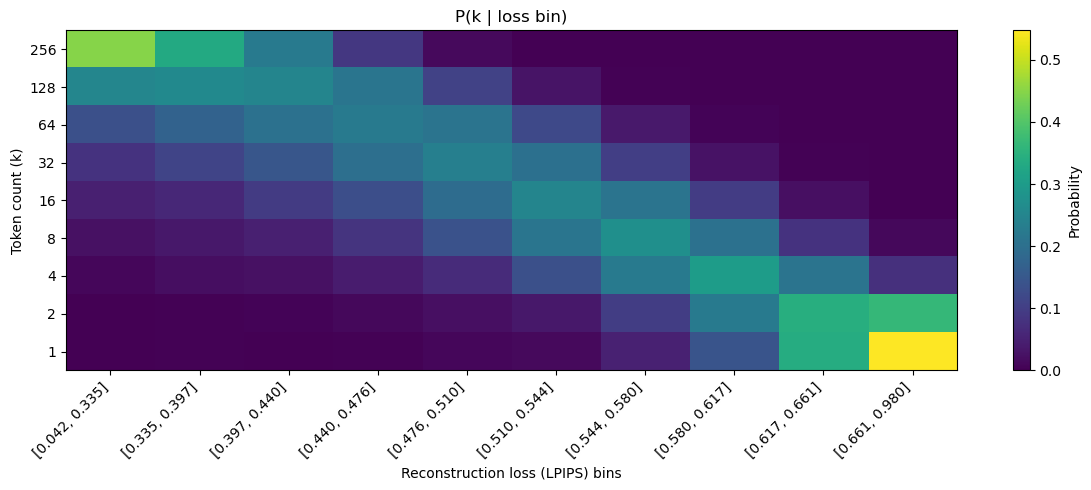

In [23]:
k_values = [1,2,4,8,16,32,64,128,256]
print(ds[0])
bin_edges, M = plot_k_vs_loss_heatmap(ds, k_values, num_bins=10, normalize="prob")


In [24]:
def entropy(p, eps=1e-12):
    p = np.asarray(p, dtype=float)
    p = p / (p.sum() + eps)
    return -np.sum(p * np.log(p + eps))


In [25]:
# From plot_k_vs_loss_heatmap
# M has shape [num_k, num_bins]
# Each column sums to 1 (probabilities)

# baseline_dist[b] = probability vector over k
baseline_dist = [M[:, b] for b in range(M.shape[1])]

In [29]:
def conditioned_k_distribution(dp, models, k_values, tau=0.02):
    loss = float(dp["LPIPS"])
    density = float(dp["local_density"])
    lid = float(dp["lid"])

    ks = [k for k in k_values if k in models]
    preds = np.array([
        abs(models[k].predict([[density, lid]])[0] - loss)
        for k in ks
    ])

    weights = np.exp(-preds / tau)
    weights /= weights.sum()

    return ks, weights


In [30]:
def entropy_by_loss_bin(
    ds,
    bin_edges,
    baseline_dist,
    models,
    k_values,
    tau=0.02,
):
    num_bins = len(baseline_dist)

    ent_base = [[] for _ in range(num_bins)]
    ent_cond = [[] for _ in range(num_bins)]

    for dp in ds:
        loss = float(dp["LPIPS"])

        # assign bin
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))

        # baseline entropy
        ent_base[b].append(entropy(baseline_dist[b]))

        # conditioned entropy
        ks, p = conditioned_k_distribution(dp, models, k_values, tau)
        ent_cond[b].append(entropy(p))

    # average per bin
    ent_base = np.array([np.mean(v) for v in ent_base])
    ent_cond = np.array([np.mean(v) for v in ent_cond])

    return ent_base, ent_cond


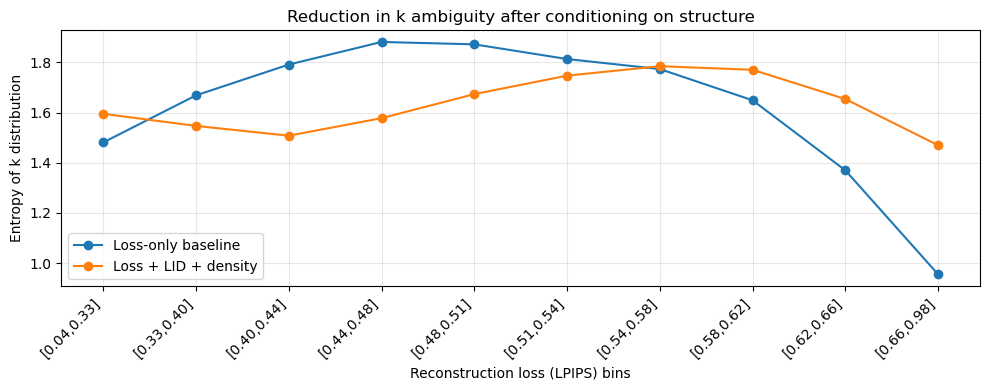

In [31]:
import matplotlib.pyplot as plt

def plot_entropy_reduction(bin_edges, ent_base, ent_cond):
    x = np.arange(len(ent_base))

    plt.figure(figsize=(10,4))
    plt.plot(x, ent_base, marker="o", label="Loss-only baseline")
    plt.plot(x, ent_cond, marker="o", label="Loss + LID + density")

    plt.xticks(
        x,
        [f"[{bin_edges[i]:.2f},{bin_edges[i+1]:.2f}]" for i in range(len(x))],
        rotation=45,
        ha="right",
    )
    plt.ylabel("Entropy of k distribution")
    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.title("Reduction in k ambiguity after conditioning on structure")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

ent_base, ent_cond = entropy_by_loss_bin(
    ds,
    bin_edges,
    baseline_dist,
    models,
    k_values,
    tau=0.05,
)

plot_entropy_reduction(bin_edges, ent_base, ent_cond)

In [32]:
import numpy as np

def safe_nll(p, idx, eps=1e-12):
    """
    Compute -log p[idx] safely.
    
    p   : probability vector over k
    idx : index of the true k in that vector
    """
    return -np.log(p[idx] + eps)


In [33]:
# Fixed k grid (same one used everywhere else)
k_values = list(k_values)  # ensure list
k_to_idx = {k: i for i, k in enumerate(k_values)}


In [34]:
def compute_baseline_nll(ds, bin_edges, baseline_dist, k_to_idx):
    """
    Compute average NLL for the baseline:
      p_base(k | loss bin)

    baseline_dist[b] is a probability vector over k_values
    """
    nlls = []

    num_bins = len(baseline_dist)

    for dp in ds:
        loss = float(dp["LPIPS"])
        true_k = int(dp["k_value"])

        # Skip if k is not in our grid
        if true_k not in k_to_idx:
            continue

        # Assign LPIPS bin
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))

        # Baseline probability distribution for this bin
        p_base = baseline_dist[b]

        # Index of true k
        idx = k_to_idx[true_k]

        # NLL contribution
        nlls.append(safe_nll(p_base, idx))

    return float(np.mean(nlls))


In [35]:
def compute_heuristic_nll(ds, models, k_values, k_to_idx, tau=0.02):
    """
    Compute average NLL for the heuristic method:
      p_method(k | loss, lid, density)
    """
    nlls = []

    for dp in ds:
        true_k = int(dp["k_value"])

        # Skip if k not in grid
        if true_k not in k_to_idx:
            continue

        # Get sample-specific distribution
        ks, p = conditioned_k_distribution(dp, models, k_values, tau=tau)

        # Build a full probability vector aligned with k_values
        p_full = np.zeros(len(k_values), dtype=float)
        for k, prob in zip(ks, p):
            if k in k_to_idx:
                p_full[k_to_idx[k]] = prob

        idx = k_to_idx[true_k]
        nlls.append(safe_nll(p_full, idx))

    return float(np.mean(nlls))


In [36]:
# Baseline NLL
baseline_nll = compute_baseline_nll(
    ds,
    bin_edges,
    baseline_dist,
    k_to_idx,
)

# Heuristic NLL
heuristic_nll = compute_heuristic_nll(
    ds,
    models,
    k_values,
    k_to_idx,
    tau=0.02,
)

print(f"Baseline NLL   : {baseline_nll:.4f}")
print(f"Heuristic NLL  : {heuristic_nll:.4f}")
print(f"NLL reduction  : {baseline_nll - heuristic_nll:.4f}")


Baseline NLL   : 1.6252
Heuristic NLL  : 1.7811
NLL reduction  : -0.1559


In [37]:
for tau in [0.005, 0.01, 0.02, 0.05, 0.1]:
    hnll = compute_heuristic_nll(ds, models, k_values, k_to_idx, tau=tau)
    print(tau, hnll)


0.005 4.931429077876504
0.01 2.718633701923763
0.02 1.781075459090031
0.05 1.5488350938118256
0.1 1.6842544786408467


In [38]:
import numpy as np

# ----------------------------
# Small helper: safe -log(p_true)
# ----------------------------
def safe_nll(p_true, eps=1e-12):
    """Return -log(p_true) with numerical safety."""
    return float(-np.log(p_true + eps))


# ----------------------------
# Baseline per-bin NLL
#   baseline_dist[b] is a prob vector over k_values for LPIPS bin b
# ----------------------------
def per_bin_nll_baseline(ds, bin_edges, baseline_dist, k_to_idx):
    """
    Compute per-LPIPS-bin average NLL for the BASELINE:
        p_base(k | loss_bin)

    For each sample:
      1) find its LPIPS bin b
      2) look up p_base = baseline_dist[b]
      3) add -log(p_base[true_k])

    Returns
    -------
    rows : list of dicts, one per bin:
      {
        'bin': b,
        'n': number of samples in bin,
        'loss_range': (bin_edges[b], bin_edges[b+1]),
        'baseline_nll': mean NLL in this bin
      }
    """
    num_bins = len(baseline_dist)

    # collect NLLs per bin
    nlls_per_bin = [[] for _ in range(num_bins)]

    for dp in ds:
        loss = float(dp["LPIPS"])
        true_k = int(dp["k_value"])

        if true_k not in k_to_idx:
            continue

        # assign bin index
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))

        p_base = baseline_dist[b]              # prob vector over k
        p_true = float(p_base[k_to_idx[true_k]])

        nlls_per_bin[b].append(safe_nll(p_true))

    rows = []
    for b in range(num_bins):
        vals = nlls_per_bin[b]
        if len(vals) == 0:
            rows.append({
                "bin": b,
                "n": 0,
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "baseline_nll": np.nan,
            })
        else:
            rows.append({
                "bin": b,
                "n": len(vals),
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "baseline_nll": float(np.mean(vals)),
            })
    return rows


# ----------------------------
# Heuristic per-bin NLL
#   Use your conditioned_k_distribution(dp, models, k_values, tau) -> (ks_subset, probs_subset)
# ----------------------------
def per_bin_nll_heuristic(ds, bin_edges, models, k_values, k_to_idx, tau=0.02):
    """
    Compute per-LPIPS-bin average NLL for the HEURISTIC:
        p_method(k | loss, lid, density)

    For each sample:
      1) find its LPIPS bin b
      2) compute sample-specific distribution (ks, probs) via conditioned_k_distribution
      3) read off p(true_k) from that distribution (0 if missing)
      4) add -log(p(true_k))

    Returns
    -------
    rows : list of dicts, one per bin:
      {
        'bin': b,
        'n': number of samples in bin,
        'loss_range': (bin_edges[b], bin_edges[b+1]),
        'heuristic_nll': mean NLL in this bin
      }
    """
    num_bins = len(bin_edges) - 1

    nlls_per_bin = [[] for _ in range(num_bins)]

    for dp in ds:
        loss = float(dp["LPIPS"])
        true_k = int(dp["k_value"])

        if true_k not in k_to_idx:
            continue

        # assign bin index
        b = int(np.searchsorted(bin_edges, loss, side="right") - 1)
        b = max(0, min(b, num_bins - 1))

        # sample-specific distribution over a subset of ks
        ks, probs = conditioned_k_distribution(dp, models, k_values, tau=tau)

        # probability of the true k under this sample-specific distribution
        # (if the true k isn't in ks, p_true = 0)
        p_true = 0.0
        for k, p in zip(ks, probs):
            if int(k) == true_k:
                p_true = float(p)
                break

        nlls_per_bin[b].append(safe_nll(p_true))

    rows = []
    for b in range(num_bins):
        vals = nlls_per_bin[b]
        if len(vals) == 0:
            rows.append({
                "bin": b,
                "n": 0,
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "heuristic_nll": np.nan,
            })
        else:
            rows.append({
                "bin": b,
                "n": len(vals),
                "loss_range": (float(bin_edges[b]), float(bin_edges[b+1])),
                "heuristic_nll": float(np.mean(vals)),
            })
    return rows


# ----------------------------
# Merge baseline + heuristic per bin (nice for printing/plotting)
# ----------------------------
def merge_per_bin_nll(rows_base, rows_heur):
    """
    Merge per-bin NLL rows from baseline + heuristic into a single list of dicts.
    Assumes same binning.
    """
    out = []
    for rb, rh in zip(rows_base, rows_heur):
        out.append({
            "bin": rb["bin"],
            "n": rb["n"],  # should match rh["n"] if both computed on same ds filtering
            "loss_range": rb["loss_range"],
            "baseline_nll": rb["baseline_nll"],
            "heuristic_nll": rh["heuristic_nll"],
            "delta_nll": (rb["baseline_nll"] - rh["heuristic_nll"]),
        })
    return out


# ----------------------------
# Example usage
# ----------------------------
k_values = [1,2,4,8,16,32,64,128,256]
k_to_idx = {k:i for i,k in enumerate(k_values)}

# baseline_dist you already have from the heatmap code:
# baseline_dist = [M[:, b] for b in range(M.shape[1])]

rows_b = per_bin_nll_baseline(ds, bin_edges, baseline_dist, k_to_idx)
rows_h = per_bin_nll_heuristic(ds, bin_edges, models, k_values, k_to_idx, tau=0.05)
rows = merge_per_bin_nll(rows_b, rows_h)

for r in rows:
    lo, hi = r["loss_range"]
    print(
        f"Bin {r['bin']:02d} n={r['n']:5d} loss[{lo:.3f},{hi:.3f}] | "
        f"NLL base={r['baseline_nll']:.3f} method={r['heuristic_nll']:.3f} | "
        f"Δ(base-method)={r['delta_nll']:.3f}"
    )


Bin 00 n= 3600 loss[0.042,0.335] | NLL base=1.481 method=1.528 | Δ(base-method)=-0.047
Bin 01 n= 3600 loss[0.335,0.397] | NLL base=1.668 method=1.326 | Δ(base-method)=0.342
Bin 02 n= 3600 loss[0.397,0.440] | NLL base=1.791 method=1.310 | Δ(base-method)=0.481
Bin 03 n= 3600 loss[0.440,0.476] | NLL base=1.881 method=1.440 | Δ(base-method)=0.441
Bin 04 n= 3600 loss[0.476,0.510] | NLL base=1.872 method=1.621 | Δ(base-method)=0.251
Bin 05 n= 3600 loss[0.510,0.544] | NLL base=1.813 method=1.764 | Δ(base-method)=0.049
Bin 06 n= 3600 loss[0.544,0.580] | NLL base=1.773 method=1.886 | Δ(base-method)=-0.113
Bin 07 n= 3600 loss[0.580,0.617] | NLL base=1.649 method=1.874 | Δ(base-method)=-0.225
Bin 08 n= 3600 loss[0.617,0.661] | NLL base=1.369 method=1.607 | Δ(base-method)=-0.238
Bin 09 n= 3600 loss[0.661,0.980] | NLL base=0.955 method=1.133 | Δ(base-method)=-0.178


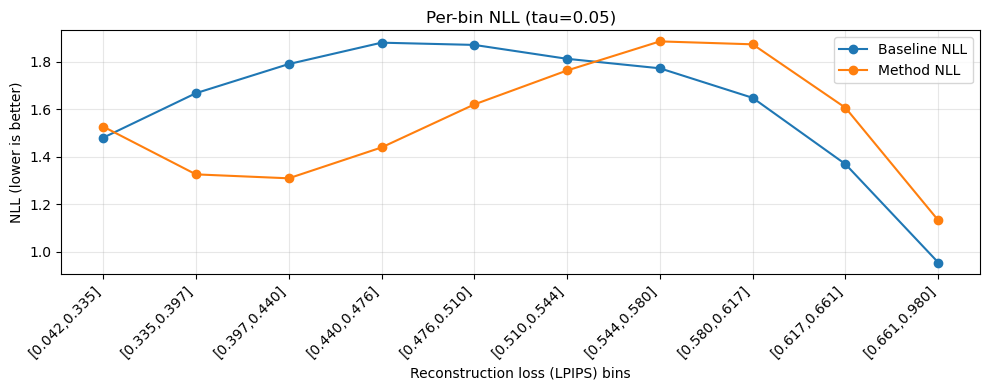

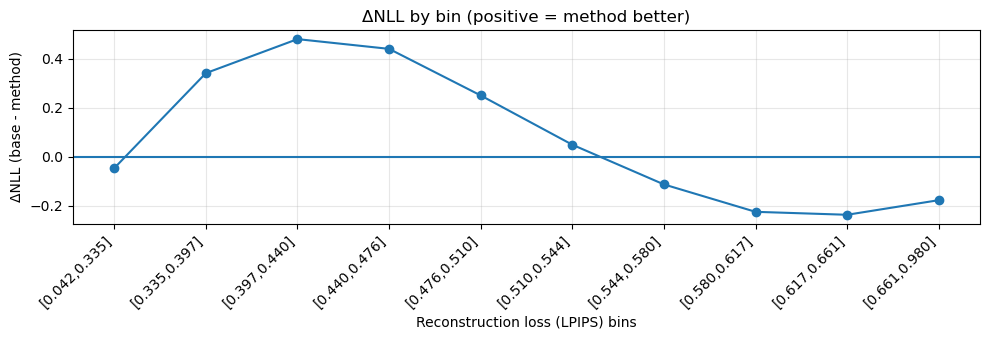

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_per_bin_nll(rows, title="Per-bin NLL: baseline vs method"):
    """
    Plot baseline vs method NLL per LPIPS bin, plus the delta (baseline - method).

    rows: list of dicts like:
      {
        'bin': int,
        'n': int,
        'loss_range': (lo, hi),
        'baseline_nll': float,
        'heuristic_nll': float,
        'delta_nll': float   # baseline - method
      }
    """
    rows = sorted(rows, key=lambda r: r["bin"])

    bins = np.array([r["bin"] for r in rows], dtype=int)
    base = np.array([r["baseline_nll"] for r in rows], dtype=float)
    meth = np.array([r["heuristic_nll"] for r in rows], dtype=float)
    delta = np.array([r["delta_nll"] for r in rows], dtype=float)

    xlabels = [f"[{r['loss_range'][0]:.3f},{r['loss_range'][1]:.3f}]" for r in rows]

    # --- Plot 1: baseline vs method NLL ---
    plt.figure(figsize=(10, 4))
    plt.plot(bins, base, marker="o", label="Baseline NLL")
    plt.plot(bins, meth, marker="o", label="Method NLL")
    plt.xticks(bins, xlabels, rotation=45, ha="right")
    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.ylabel("NLL (lower is better)")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: delta NLL (baseline - method) ---
    plt.figure(figsize=(10, 3.5))
    plt.plot(bins, delta, marker="o")
    plt.axhline(0.0)
    plt.xticks(bins, xlabels, rotation=45, ha="right")
    plt.xlabel("Reconstruction loss (LPIPS) bins")
    plt.ylabel("ΔNLL (base - method)")
    plt.title("ΔNLL by bin (positive = method better)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# Example usage:
rows_b = per_bin_nll_baseline(ds, bin_edges, baseline_dist, k_to_idx)
rows_h = per_bin_nll_heuristic(ds, bin_edges, models, k_values, k_to_idx, tau=0.05)
rows = merge_per_bin_nll(rows_b, rows_h)
plot_per_bin_nll(rows, title="Per-bin NLL (tau=0.05)")